# Chapter10 - LSTM

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")

In [22]:
df = pd.read_csv("dataset_demand_forecasting_sd.csv")
df.head()

,Date,Sales
0,2014-01-01,11219
1,2014-01-02,12745
2,2014-01-03,10498
3,2014-01-04,12028
4,2014-01-05,13900


### Timeseries Based

In [23]:
df.head()

,Date,Sales
0,2014-01-01,11219
1,2014-01-02,12745
2,2014-01-03,10498
3,2014-01-04,12028
4,2014-01-05,13900


In [24]:
len(df)

2547

In [4]:
df['Sales'] = df["Sales"].rolling(window=20).mean()
df = df.dropna()

In [25]:
training = df[df["Date"]< '2018-01-01'].Sales.values.reshape(-1, 1)
testing = df[df["Date"]>= '2018-01-01'].Sales.values.reshape(-1, 1)

In [26]:
training

array([[11219],
       [12745],
       [10498],
       ...,
       [57683],
       [64561],
       [71068]], dtype=int64)

In [7]:
testing

array([[ 53866.45],
       [ 54795.8 ],
       [ 56178.75],
       ...,
       [ 98101.  ],
       [ 99879.4 ],
       [100624.25]])

In [8]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [9]:
df

,Date,Sales
19,2014-01-20,11956.60
20,2014-01-21,12030.30
21,2014-01-22,11959.45
22,2014-01-23,11958.55
23,2014-01-24,11994.70
...,...,...
2542,2020-12-19,98910.15
2543,2020-12-20,98268.45
2544,2020-12-21,98101.00
2545,2020-12-22,99879.40


In [10]:
dataset = df[["Sales"]].values
dataset = dataset.astype('float32')

In [11]:
dataset

array([[ 11956.6 ],
       [ 12030.3 ],
       [ 11959.45],
       ...,
       [ 98101.  ],
       [ 99879.4 ],
       [100624.25]], dtype=float32)

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [13]:
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1693 835


In [14]:
import numpy as np
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [15]:
look_back = 100
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [16]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [17]:
model = Sequential()
model.add(LSTM(2, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
1592/1592 - 2s - loss: 8.0216e-04
Epoch 2/10
1592/1592 - 1s - loss: 5.1081e-04
Epoch 3/10
1592/1592 - 1s - loss: 3.8926e-04
Epoch 4/10
1592/1592 - 1s - loss: 3.1265e-04
Epoch 5/10
1592/1592 - 1s - loss: 2.6811e-04
Epoch 6/10
1592/1592 - 1s - loss: 2.4346e-04
Epoch 7/10
1592/1592 - 1s - loss: 2.3247e-04
Epoch 8/10
1592/1592 - 1s - loss: 2.0382e-04
Epoch 9/10
1592/1592 - 1s - loss: 1.9908e-04
Epoch 10/10
1592/1592 - 1s - loss: 1.8915e-04


In [18]:
trainY.ravel()

array([0.03902357, 0.03651177, 0.03368702, ..., 0.36833033, 0.36092746,
       0.35291854], dtype=float32)

In [19]:
import math
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY.ravel()])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY.ravel()])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1203.48 RMSE
Test Score: 8399.98 RMSE


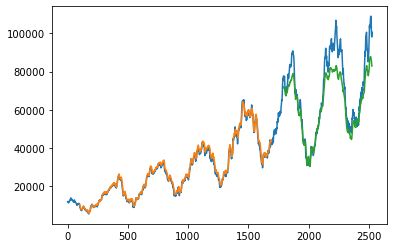

In [20]:
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()